# Introduction
This dataset represents Bulk tissue expression RNA-Seq samples from GTEx Analysis V10 release.


The input files were found at [https://www.gtexportal.org/home/downloads/adult-gtex/bulk_tissue_expression]

# Libraries
Import the necessary libraries

In [3]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
print(ad.__version__)
from tqdm import tqdm

0.11.4


# Import Gene/Transcript TPMs 
Import the gene expression data from gTEX. 

* The first two columns contain the gene/transcript IDs and a description
* The values are a matrix of 19616 tissue sample IDs as named in each column by 59033 genes as named in each row from RNASeQCv2.4.2.

In [4]:

#genes_f = "gtex_bulk_tissue_expression/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"

genes_f = "https://storage.googleapis.com/adult-gtex/bulk-gex/v10/rna-seq/GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.gct.gz"

first get the gene/transcript meta data from the quantification files

In [8]:
# nrows = 1000
nrows = None
chunkSize = 1000
if nrows:
    genes_meta_df = pd.read_csv(
        genes_f, 
        sep="\t", skiprows=2, nrows=nrows,
        usecols=[0,1], compression='gzip')
else:
    total_iterations = np.ceil(59036 / chunkSize)
    genes_meta_df = pd.concat(
        [chunk for chunk in tqdm(pd.read_csv(genes_f, sep="\t", skiprows=2, usecols=[0,1], compression='gzip', chunksize=chunkSize), desc='Loading data', total=total_iterations)]
    )
genes_meta_df.set_index('Name', inplace=True)

Loading data: 100%|██████████| 60/60.0 [00:24<00:00,  2.48it/s]


then get the TPMs from the quantification files

In [9]:

if nrows:
    genes_counts_df = pd.read_csv(
        genes_f, 
        sep="\t", skiprows=2, nrows=nrows,
        usecols=range(2,2+19616), compression='gzip', dtype=np.float64)
else:
    genes_counts_df = pd.concat(
        [chunk for chunk in tqdm(pd.read_csv(genes_f, sep="\t", skiprows=2, usecols=range(2,2+19616), compression='gzip', dtype=np.float64, chunksize=chunkSize), desc='Loading data', total=total_iterations)]
    )

Loading data: 100%|██████████| 60/60.0 [32:44<00:00, 32.74s/it]   


In [10]:
genes_counts_df.loc[:,"GTEX-1117F-0226-SM-5GZZ7"].head()

0    0.000000
1    9.678340
2    0.000000
3    0.073473
4    0.000000
Name: GTEX-1117F-0226-SM-5GZZ7, dtype: float64

# Import meta data for the gene/transcripts

In [11]:
def parse_gtf_attributes(attr_string):
    attributes = {}
    for item in attr_string.strip().split(';'):
        if item.strip():
            parts = item.strip().split(' ', 1) # Split only on the first space
            if len(parts) == 2:
                key = parts[0].strip()
                value = parts[1].strip().strip('"') # Remove quotes
                attributes[key] = value
    return attributes
parse_gtf_attributes('gene_id "ENSG00000223972.5"; transcript_id "ENSG00000223972.5"; gene_type "transcribed_unprocessed_pseudogene"')

{'gene_id': 'ENSG00000223972.5',
 'transcript_id': 'ENSG00000223972.5',
 'gene_type': 'transcribed_unprocessed_pseudogene'}

In [12]:
#from gtfparse import read_gtf

# returns GTF with essential columns such as "feature", "seqname", "start", "end"
# alongside the names of any optional keys which appeared in the attribute column
gtf_f = "https://storage.googleapis.com/adult-gtex/references/v10/reference-tables/gencode.v39.GRCh38.genes.gtf"
gtf_df = pd.read_csv(gtf_f, sep="\t", comment="#", header=None, dtype=str)
gtf_df.columns = ["seqname", "source", "feature", "start", "end", "score", "strand", "frame", "attribute"]
gene_gtf_df = gtf_df[gtf_df["feature"] == "gene"].copy()
add_columns = ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name']
gene_gtf_df.loc[:, add_columns] = None

for index, row in gene_gtf_df.iterrows():
    attributes_dict = parse_gtf_attributes(row['attribute'])
    #gene_gtf_df.at[index,'attribute'] = attributes_dict
    for col in add_columns:
        if col in attributes_dict.keys():
            gene_gtf_df.loc[index,col] = attributes_dict[col]
genes_meta_df.index.name =None
gene_gtf_df = gene_gtf_df.set_index('gene_id').copy()
gene_gtf_df.index.name =None
gene_merged_meta_df = genes_meta_df.merge(gene_gtf_df, left_index=True, right_index=True, how='left')
print(f"Number of genes in metadata: {len(genes_meta_df)}")
print(f"Number of genes in gtf: {len(gene_gtf_df)}")
gene_merged_meta_df.head()


Number of genes in metadata: 59033
Number of genes in gtf: 59033


,Description,seqname,source,feature,start,end,score,strand,frame,attribute,transcript_id,gene_type,gene_name,transcript_type,transcript_name
ENSG00000223972.5,DDX11L1,chr1,HAVANA,gene,11869,14403,.,+,.,"gene_id ""ENSG00000223972.5""; transcript_id ""EN...",ENSG00000223972.5,transcribed_unprocessed_pseudogene,DDX11L1,transcribed_unprocessed_pseudogene,DDX11L1
ENSG00000227232.5,WASH7P,chr1,HAVANA,gene,14410,29553,.,-,.,"gene_id ""ENSG00000227232.5""; transcript_id ""EN...",ENSG00000227232.5,unprocessed_pseudogene,WASH7P,unprocessed_pseudogene,WASH7P
ENSG00000278267.1,MIR6859-1,chr1,ENSEMBL,gene,17369,17436,.,-,.,"gene_id ""ENSG00000278267.1""; transcript_id ""EN...",ENSG00000278267.1,miRNA,MIR6859-1,miRNA,MIR6859-1
ENSG00000243485.5,MIR1302-2HG,chr1,HAVANA,gene,29571,31109,.,+,.,"gene_id ""ENSG00000243485.5""; transcript_id ""EN...",ENSG00000243485.5,lncRNA,MIR1302-2HG,lncRNA,MIR1302-2HG
ENSG00000237613.2,FAM138A,chr1,HAVANA,gene,34554,36081,.,-,.,"gene_id ""ENSG00000237613.2""; transcript_id ""EN...",ENSG00000237613.2,lncRNA,FAM138A,lncRNA,FAM138A


# Import meta data for the samples

In [13]:
sample_meta_f = "https://storage.googleapis.com/adult-gtex/annotations/v10/metadata-files/GTEx_Analysis_v10_Annotations_SampleAttributesDS.txt"
total_iterations = np.ceil(48232 / chunkSize)
sample_meta_df = pd.concat(
    [chunk for chunk in tqdm(pd.read_csv(sample_meta_f, sep="\t", chunksize=chunkSize), desc='Loading data', total=total_iterations)]
)

Loading data: 100%|██████████| 49/49.0 [00:00<00:00, 126.07it/s]


limit sample meta information to the samples used for the RNA-seq and relavent columns

I used excel to open `GTEx_Analysis_v10_Annotations_SampleAttributesDD.xlsx` to distinuish the columns of interest. The columns I used are:
* SAMPID: Sample ID, GTEx Public Sample ID
* SMTS: Tissue Type, area from which the tissue sample was taken. This is a parent value to SMTSD. (ie. Adipose Tissue, Adrenal Gland, Bladder, Blood, Blood Vessel, Bone Marrow, Brain, Breast, Cervix Uteri, Colon, Esophagus, Fallopian Tube, Heart, Kidney, Liver, Lung, Muscle, Nerve, Ovary, Pancreas, Pituitary, Prostate, Skin, Spleen, Stomach, Testis, Thyroid, Uterus, Vagina)
* SMTSD: Tissue Type, more specific detail of tissue type


In [14]:
rnaseq_samp_meta_df = sample_meta_df.loc[sample_meta_df["SMAFRZE"]=="RNASEQ",["SAMPID", "SMTS", "SMTSD"]].copy()
rnaseq_samp_meta_df = (
    rnaseq_samp_meta_df.rename(
        columns={
            "SMTS": "TISSUE",
            "SMTSD": "TISSUE_DETAILED"
        }
    )
)
rnaseq_samp_meta_df.set_index("SAMPID", inplace=True)
rnaseq_samp_meta_df = rnaseq_samp_meta_df.loc[genes_counts_df.columns.tolist(),:]
print(rnaseq_samp_meta_df.shape)
rnaseq_samp_meta_df.head()

(19616, 2)


,TISSUE,TISSUE_DETAILED
SAMPID,,
GTEX-1117F-0005-SM-HL9SH,Blood,Whole Blood
GTEX-1117F-0011-R10b-SM-GI4VE,Brain,Brain - Frontal Cortex (BA9)
GTEX-1117F-0011-R11b-SM-GIN8R,Brain,Brain - Cerebellar Hemisphere
GTEX-1117F-0011-R2b-SM-GI4VL,Brain,Brain - Substantia nigra
GTEX-1117F-0011-R3a-SM-GJ3PJ,Brain,Brain - Anterior cingulate cortex (BA24)


# Initializing AnnData
See the following tutorial at [https://anndata.readthedocs.io/en/latest/tutorials/notebooks/getting-started.html]


Build an AnnData object with gene expression counts

In [15]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://raw.githubusercontent.com/scverse/anndata/main/docs/_static/img/anndata_schema.svg"
      , width=300, height=300)

In [16]:
counts = csr_matrix(
    genes_counts_df.transpose(), 
    dtype=np.float32)
adata = ad.AnnData(counts)
adata

AnnData object with n_obs × n_vars = 19616 × 59033

We see that AnnData provides a representation with summary statistics of the data. The initial data we passed are accessible as a sparse matrix using adata.X

In [17]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 610491479 stored elements and shape (19616, 59033)>

Now, we provide the index to both the `obs` and `var` axes using `.obs_names` (resp. `.var_names`).

* `adata.var_names` = transcript or gene names
* `adata.obs_names` = sample names

In [18]:
adata.var_names = genes_meta_df.index.tolist()
adata.obs_names = genes_counts_df.columns.tolist()
#print(adata.var_names[0:10])
print(adata.var_names[-10:-1])
#print(adata.obs_names[0:10])
print(adata.obs_names[-10:-1])

Index(['ENSG00000198886.2', 'ENSG00000210176.1', 'ENSG00000210184.1',
       'ENSG00000210191.1', 'ENSG00000198786.2', 'ENSG00000198695.2',
       'ENSG00000210194.1', 'ENSG00000198727.2', 'ENSG00000210195.2'],
      dtype='object')
Index(['GTEX-ZZPU-1326-SM-5GZWS', 'GTEX-ZZPU-1426-SM-5GZZ6',
       'GTEX-ZZPU-1826-SM-5E43L', 'GTEX-ZZPU-2126-SM-5EGIU',
       'GTEX-ZZPU-2226-SM-5EGIV', 'GTEX-ZZPU-2326-SM-GOQYU',
       'GTEX-ZZPU-2426-SM-5E44I', 'GTEX-ZZPU-2526-SM-GOQZ3',
       'GTEX-ZZPU-2626-SM-5E45Y'],
      dtype='object')


## Subsetting AnnData

These index values can be used to subset the AnnData, which provides a view of the AnnData object. We can imagine this to be useful to subset the AnnData to particular cell types or gene modules of interest. The rules for subsetting AnnData are quite similar to that of a Pandas DataFrame. You can use values in the `obs/var_names`, boolean masks, or cell index integers.

In [19]:
adata[['GTEX-1117F-0226-SM-5GZZ7', 'GTEX-1117F-0011-R10b-SM-GI4VE'], ['ENSG00000223972.5', 'ENSG00000227232.5']]

View of AnnData object with n_obs × n_vars = 2 × 2

# Adding aligned metadata

## Observation/Variable level

So we have the core of our object and now we’d like to add metadata at both the observation and variable levels. This is pretty simple with AnnData, both `adata.obs` and `adata.var` are Pandas DataFrames.

In [20]:
## Categoricals are preferred for efficiency
adata.obs["TISSUE"] = pd.Categorical(rnaseq_samp_meta_df['TISSUE'])  
adata.obs["TISSUE_DETAILED"] = pd.Categorical(rnaseq_samp_meta_df['TISSUE_DETAILED'])  
adata.obs

,TISSUE,TISSUE_DETAILED
GTEX-1117F-0005-SM-HL9SH,Blood,Whole Blood
GTEX-1117F-0011-R10b-SM-GI4VE,Brain,Brain - Frontal Cortex (BA9)
GTEX-1117F-0011-R11b-SM-GIN8R,Brain,Brain - Cerebellar Hemisphere
GTEX-1117F-0011-R2b-SM-GI4VL,Brain,Brain - Substantia nigra
GTEX-1117F-0011-R3a-SM-GJ3PJ,Brain,Brain - Anterior cingulate cortex (BA24)
...,...,...
GTEX-ZZPU-2326-SM-GOQYU,Nerve,Nerve - Tibial
GTEX-ZZPU-2426-SM-5E44I,Blood Vessel,Artery - Tibial
GTEX-ZZPU-2526-SM-GOQZ3,Skin,Skin - Sun Exposed (Lower leg)
GTEX-ZZPU-2626-SM-5E45Y,Muscle,Muscle - Skeletal


In [21]:
#if run_transcripts:
#    adata.var["gene_id"] = gene_merged_meta_df['gene_id']
#else:
#    adata.var["Description"] = gene_merged_meta_df['Description']
#    adata.var["transcript_id"]
adata.var = gene_merged_meta_df.copy()

We can also see now that the AnnData representation has been updated:

In [22]:
adata

AnnData object with n_obs × n_vars = 19616 × 59033
    obs: 'TISSUE', 'TISSUE_DETAILED'
    var: 'Description', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name'

## Subsetting using metadata

We can also subset the AnnData using `.obs` and `.var` attributes, which are Pandas DataFrames. This is useful to filter the AnnData object to only those samples or genes that are of interest. For example, we can filter the AnnData to only those samples that have a particular tissue type:

In [23]:
adata[adata.obs.TISSUE == "Adipose Tissue", :]

View of AnnData object with n_obs × n_vars = 1301 × 59033
    obs: 'TISSUE', 'TISSUE_DETAILED'
    var: 'Description', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name'

We can also subset using the transcript or gene ID meta data. For example, we can filter the AnnData to only those genes that are on chromosome 12:

In [24]:
adata[:,adata.var.seqname == "chr12"]

View of AnnData object with n_obs × n_vars = 19616 × 2953
    obs: 'TISSUE', 'TISSUE_DETAILED'
    var: 'Description', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name'

# Observation/variable-level matrices
We might also have metadata at either level that has many dimensions to it, such as a UMAP embedding of the data. For this type of metadata, AnnData has the `.obsm/.varm` attributes. We use keys to identify the different matrices we insert. The restriction of `.obsm/.varm` are that `.obsm` matrices must length equal to the number of observations as `.n_obs` and `.varm` matrices must length equal to .n_vars. They can each independently have different number of dimensions.

In the code below we make a randomly generated matrix that we can interpret as a UMAP embedding of the data we’d like to store, as well as some random gene-level metadata. However, this code is within a False conditional so it will not run because we do not have any UMAP embeddings or gene-level metadata to add to the AnnData object.

In [25]:
adata

AnnData object with n_obs × n_vars = 19616 × 59033
    obs: 'TISSUE', 'TISSUE_DETAILED'
    var: 'Description', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name'

In [26]:
if 1==0: # deprecated
    import umap
    reducer = umap.UMAP(random_state=42)
    embeddings = reducer.fit_transform(np.log1p(adata.X))
else:
    import scanpy as sc

    # Preprocessing
    sc.pp.log1p(adata)               # Applies log1p to adata.X (in-place)
    sc.pp.neighbors(adata)           # Required before running UMAP
    sc.tl.umap(adata, random_state=42)

    # Access UMAP coordinates
    embeddings = adata.obsm["X_umap"]

/Users/samanthaklasfeld/Desktop/Github/GenomicVista/.pixi/envs/default/lib/python3.13/site-packages/scanpy/neighbors/__init__.py:586: UserWarning: You’re trying to run this on 59033 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  X = _choose_representation(self._adata, use_rep=use_rep, n_pcs=n_pcs)
/Users/samanthaklasfeld/Desktop/Github/GenomicVista/.pixi/envs/default/lib/python3.13/site-packages/sklearn/manifold/_spectral_embedding.py:328: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [27]:
embeddings.shape

(19616, 2)

In [28]:
adata.obsm["Xlog_umap"] = embeddings

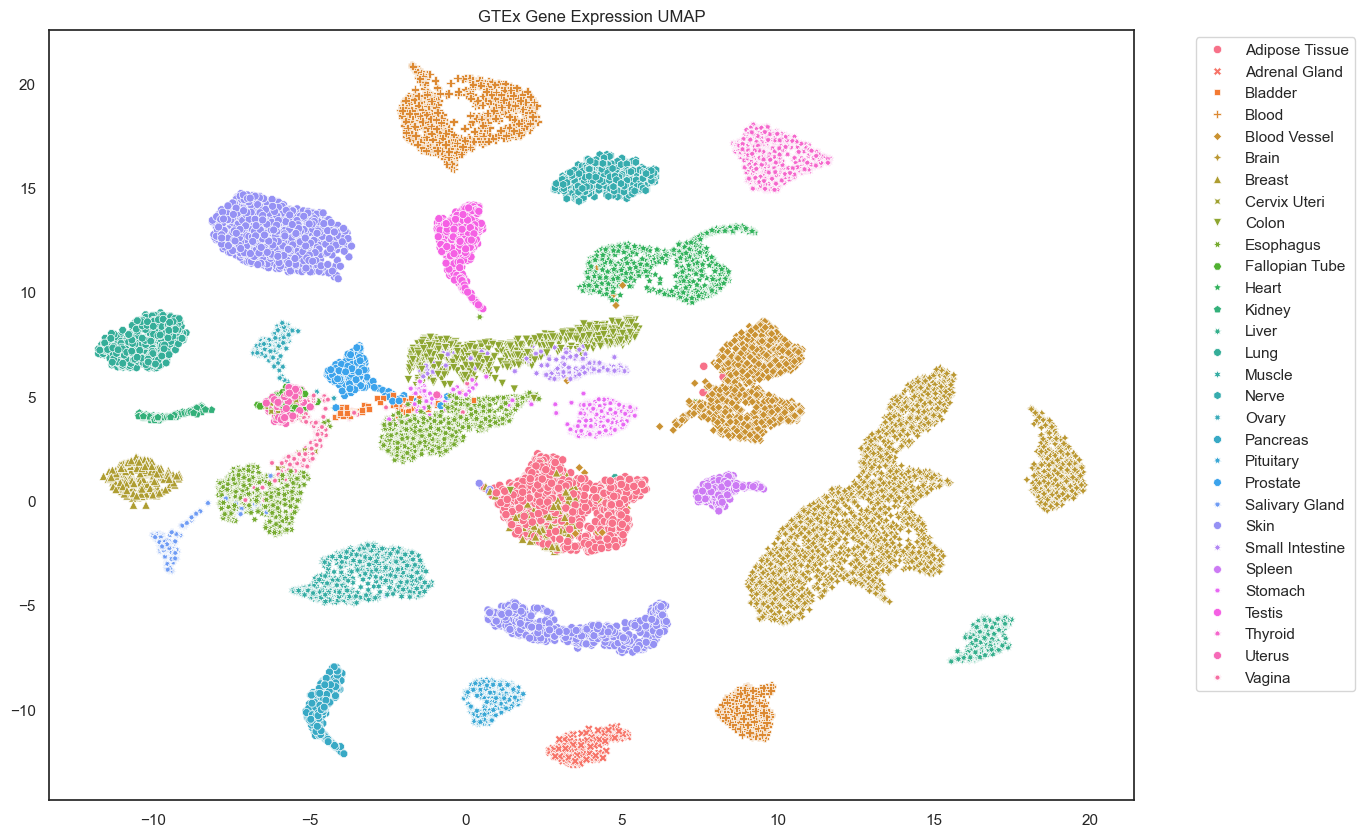

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", context='notebook', rc={'figure.figsize':(14,10)})
tissue_dict = {value: index for index, value in enumerate(list(adata.obs["TISSUE"].cat.categories))}
colors_pal = sns.color_palette("husl", len(tissue_dict))  # Use a color palette with enough colors for each tissue type
fig, ax = plt.subplots()
ax = sns.scatterplot(
    x=adata.obsm["Xlog_umap"][:, 0], 
    y=adata.obsm["Xlog_umap"][:, 1], 
    hue=adata.obs["TISSUE"].map(lambda x: tissue_dict[x]),
    style=adata.obs["TISSUE"].map(lambda x: tissue_dict[x]),
    palette=colors_pal)
handles, labels  =  ax.get_legend_handles_labels()
ax.legend(handles, list(tissue_dict.keys()), bbox_to_anchor=(1.05, 1))
ax.set_title("GTEx Gene Expression UMAP")
plt.show()

Again, the AnnData representation is updated.

In [32]:
adata

AnnData object with n_obs × n_vars = 19616 × 59033
    obs: 'TISSUE', 'TISSUE_DETAILED'
    var: 'Description', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name'
    uns: 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'Xlog_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

A few more notes about .obsm/.varm

The “array-like” metadata can originate from a Pandas DataFrame, scipy sparse matrix, or numpy dense array.

When using scanpy, their values (columns) are not easily plotted, where instead items from .obs are easily plotted on, e.g., UMAP plots.



# Unstructured metadata
AnnData has .uns, which allows for any unstructured metadata. This can be anything, like a list or a dictionary with some general information that was useful in the analysis of our data.

In [33]:
adata.uns["Release"] = "GTEx v10"
adata.uns["Type"] = "RNASeq Bulk Tissue Expression"
adata.uns["Name"] = genes_f
adata.uns["Description"] = "Gene Expression Transcripts Per Million (TPM) from RNASeQCv2.4.2."

# Layers
Finally, we may have different forms of our original core data, perhaps one that is normalized and one that is not. These can be stored in different layers in AnnData. For example, let’s log transform the original data and store it in a layer:

In [34]:
adata.layers["log_transformed"] = np.log1p(adata.X)
adata

AnnData object with n_obs × n_vars = 19616 × 59033
    obs: 'TISSUE', 'TISSUE_DETAILED'
    var: 'Description', 'seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'Release', 'Type', 'Name', 'Description'
    obsm: 'X_pca', 'X_umap', 'Xlog_umap'
    varm: 'PCs'
    layers: 'log_transformed'
    obsp: 'distances', 'connectivities'

# Conversion to DataFrames
We can also ask AnnData to return us a DataFrame from one of the layers:

In [35]:
adata.to_df(layer="log_transformed")

,ENSG00000223972.5,ENSG00000227232.5,ENSG00000278267.1,ENSG00000243485.5,ENSG00000237613.2,ENSG00000268020.3,ENSG00000240361.2,ENSG00000186092.7,ENSG00000238009.6,ENSG00000233750.3,...,ENSG00000198886.2,ENSG00000210176.1,ENSG00000210184.1,ENSG00000210191.1,ENSG00000198786.2,ENSG00000198695.2,ENSG00000210194.1,ENSG00000198727.2,ENSG00000210195.2,ENSG00000210196.2
GTEX-1117F-0005-SM-HL9SH,0.000000,0.613746,0.0,0.000000,0.000000,0.000000,0.022667,0.000000,0.030904,0.036513,...,2.046102,0.000000,0.000000,0.000000,1.729782,1.717785,0.000000,1.955492,0.000000,0.000000
GTEX-1117F-0011-R10b-SM-GI4VE,0.000000,0.924870,0.0,0.085885,0.000000,0.000000,0.027932,0.044498,0.038009,0.055452,...,2.469373,0.575607,0.842821,0.000000,2.292264,2.248572,1.102533,2.421600,0.877777,0.580052
GTEX-1117F-0011-R11b-SM-GIN8R,0.000000,1.228165,0.0,0.033067,0.000000,0.065904,0.059142,0.073428,0.014190,0.016818,...,2.491010,0.763608,0.000000,0.939553,2.324235,2.290434,1.360845,2.447636,0.994083,1.140556
GTEX-1117F-0011-R2b-SM-GI4VL,0.000000,0.866211,0.0,0.000000,0.017354,0.000000,0.043692,0.061763,0.000000,0.000000,...,2.485914,0.882043,0.712105,0.839881,2.330105,2.299539,1.332471,2.442792,1.258173,1.096005
GTEX-1117F-0011-R3a-SM-GJ3PJ,0.000000,0.933697,0.0,0.000000,0.000000,0.000000,0.058533,0.032475,0.000000,0.016638,...,2.471649,0.599514,0.524440,0.751037,2.289433,2.265608,1.277709,2.414636,0.774247,1.036521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GTEX-ZZPU-2326-SM-GOQYU,0.000000,0.797051,0.0,0.039463,0.000000,0.000000,0.024540,0.039173,0.094140,0.084744,...,2.432032,0.347652,0.000000,0.340829,2.301744,2.311252,1.522790,2.407038,0.358431,0.755611
GTEX-ZZPU-2426-SM-5E44I,0.000000,0.857562,0.0,0.050646,0.000000,0.000000,0.061350,0.110128,0.168916,0.050673,...,2.373895,0.413677,0.456229,0.000000,2.316362,2.371060,1.591092,2.387142,0.000000,0.838432
GTEX-ZZPU-2526-SM-GOQZ3,0.017481,1.032331,0.0,0.000000,0.000000,0.099150,0.148803,0.011613,0.130468,0.081693,...,2.417360,0.313834,0.350378,0.307440,2.325484,2.339103,1.551076,2.410660,1.034129,0.709502
GTEX-ZZPU-2626-SM-5E45Y,0.019822,0.476920,0.0,0.000000,0.000000,0.039970,0.024132,0.186143,0.016714,0.000000,...,2.453102,0.343534,0.795257,0.000000,2.363499,2.387130,1.613510,2.443907,0.976788,0.967678


We see that the `.obs_names/.var_names` are used in the creation of this Pandas object.

# Writing the results to disk
`AnnData` comes with its own persistent HDF5-based file format: h5ad. If string columns with small number of categories aren’t yet categoricals, `AnnData` will auto-transform to categoricals.

In [ ]:
adata.write('GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.h5ad', compression="gzip")

In [1]:
!h5ls 'GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.h5ad'

In [ ]:
import zarr
adata.write_zarr('GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.zarr')


In [5]:
import zarr
adata_zarr = ad.read_zarr('./GTEx_Analysis_v10_RNASeQCv2.4.2_gene_tpm.zarr')

PathNotFoundError: nothing found at path ''